In [1]:
%load_ext autoreload
%autoreload 2

from pymongo import ASCENDING, GEOSPHERE, MongoClient
import pandas as pd
from alive_progress import alive_bar
from shapely.geometry import Point, mapping
import shapely
import json
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import geopandas as gpd
from h3 import h3
import math
import numpy as np

In [2]:
client = MongoClient('mongodb://localhost:27017/')

In [3]:
db = client.osmDataDB
coll_areas = db.areas
coll_relations = db.relations
coll_nextBikeRaw = db.nextBikeRaw

In [4]:
coll_cities = db.cities
coll_cities.create_index([("city_id", ASCENDING)])
coll_cities.create_index([("geometry", GEOSPHERE)])

'geometry_2dsphere'

In [13]:
from areas import areas_dict

In [12]:
from areas import countries_dict

In [18]:
for i, city in enumerate(list(areas_dict.keys())):
    osm_areas = [coll_areas.find_one({"osm_id": osm}) for osm in areas_dict[city]]
    geometry = osm_areas[0]["geometry"]
    if len(osm_areas) > 1:
        shapes = [shapely.geometry.shape(a['geometry']) for a in osm_areas]
        new_shape = shapely.ops.cascaded_union(shapes)
        # print(new_shape)
        geometry = shapely.geometry.mapping(new_shape)
    coll_cities.insert_one({
        'city_id': i + 1,
        'city': city,
        'osm_areas_ids': areas_dict[city],
        'geometry': geometry
    })

In [7]:
records = [r for r in coll_cities.find()]
for r in records:
    r['geometry'] = shapely.geometry.shape(r['geometry'])
    del r['_id']
df_cities = gpd.GeoDataFrame([r for r in records])

In [8]:
df_cities

,city_id,city,osm_areas_ids,geometry,accepted
0,1,Antwerpen,[59518],"POLYGON ((4.21758 51.37389, 4.21826 51.37221, ...",True
1,2,Barcelona,[347950],"MULTIPOLYGON (((2.05250 41.42416, 2.05260 41.4...",True
2,3,Berlin,[62422],"MULTIPOLYGON (((13.08835 52.41963, 13.09021 52...",True
3,4,Bern,[1686344],"MULTIPOLYGON (((6.86148 47.16563, 6.86152 47.1...",True
4,5,Bordeaux,[1667452],"POLYGON ((-0.90492 44.80807, -0.89653 44.79124...",True
...,...,...,...,...,...
56,57,Vilnius,[1529146],"POLYGON ((25.02454 54.62319, 25.02734 54.62303...",False
57,58,Warszawa,[336075],"POLYGON ((20.85169 52.20098, 20.85170 52.20084...",True
58,59,Wrocław,[2805691],"POLYGON ((16.80734 51.13895, 16.80859 51.13887...",True
59,60,Zaragoza,[345740],"MULTIPOLYGON (((-1.17373 41.64687, -1.17369 41...",True


In [9]:
source_json = df_cities.to_json()
with open('cities.geojson', 'w', encoding='utf-8') as source:
    source.write(source_json)

In [54]:
coll_stations = db.stationsInCities
coll_stations.create_index([("city_id", ASCENDING)])
coll_stations.create_index([("geometry", GEOSPHERE)])

'geometry_2dsphere'

In [9]:
city_id_cache = {}

In [55]:
for record in tqdm(coll_nextBikeRaw.find()):
    if not record['area_osm_id'] in city_id_cache:
        city = coll_cities.find_one({ 'osm_areas_ids': record['area_osm_id'] })
        city_id_cache[record['area_osm_id']] = city['city_id']
    coll_stations.insert_one({
        'name': record['name'],
        'city_id': city_id_cache[record['area_osm_id']],
        'geometry': record['geometry']
    })

11826it [00:13, 901.66it/s] 


In [52]:
def check_duplicate_areas():
    stations = coll_stations.find()
    for station in stations:
        query = { 'name': station['name'], 'city_id': station['city_id'] }
        stations_prime = coll_areas.find(query)
        for station_prime in stations_prime:
            if station['_id'] != station_prime['_id']:
                print(station['_id'], station['name'], station['city_id'])

In [53]:
check_duplicate_areas()

In [56]:
for idx, row in df_cities.iterrows():
    stations = coll_stations.count_documents({ 'city_id': row.city_id })
    df_cities.loc[idx, 'stations'] = int(stations)
    df_cities.loc[idx, 'country'] = countries_dict[row.city]["country"]
    df_cities.loc[idx, 'country_code'] = countries_dict[row.city]["code"]

In [57]:
df_cities['city_label'] = df_cities[['city', 'country_code']].agg(', '.join, axis=1)

In [58]:
distances = {}

In [59]:
def getNearestStationDistance(city_id, st):
    nearest_station = coll_stations.find_one(
        { "geometry": { "$near": { "$geometry": st['geometry'], "$minDistance": 0.1 } }, "city_id": city_id }
    )
    dist = h3.point_dist(st['geometry']['coordinates'][::-1], nearest_station['geometry']['coordinates'][::-1], unit='m')
    # print(st['geometry']['coordinates'][::-1], nearest_station['geometry']['coordinates'][::-1], dist)
    return dist

In [60]:
for city_id in df_cities.city_id:
    distances[city_id] = []
    for station in tqdm(coll_stations.find({ "city_id": city_id }), desc=str(city_id)):
        distances[city_id].append(getNearestStationDistance(city_id, station))

1: 298it [00:00, 304.47it/s]
2: 502it [00:01, 314.99it/s]
3: 305it [00:00, 308.59it/s]
4: 193it [00:00, 360.82it/s]
5: 183it [00:00, 347.24it/s]
6: 95it [00:00, 319.73it/s]
7: 148it [00:00, 311.08it/s]
8: 349it [00:01, 317.68it/s]
9: 15it [00:00, 325.41it/s]
10: 159it [00:00, 361.78it/s]
11: 100it [00:00, 296.29it/s]
12: 22it [00:00, 320.78it/s]
13: 32it [00:00, 390.80it/s]
14: 51it [00:00, 360.95it/s]
15: 88it [00:00, 270.93it/s]
16: 47it [00:00, 262.73it/s]
17: 195it [00:00, 365.65it/s]
18: 34it [00:00, 292.28it/s]
19: 96it [00:00, 305.92it/s]
20: 96it [00:00, 329.30it/s]
21: 23it [00:00, 281.98it/s]
22: 22it [00:00, 360.78it/s]
23: 75it [00:00, 272.66it/s]
24: 112it [00:00, 280.55it/s]
25: 352it [00:01, 332.23it/s]
26: 118it [00:00, 361.57it/s]
27: 17it [00:00, 370.43it/s]
28: 92it [00:00, 307.79it/s]
29: 72it [00:00, 259.37it/s]
30: 789it [00:02, 325.35it/s]
31: 96it [00:00, 349.51it/s]
32: 422it [00:01, 322.92it/s]
33: 264it [00:00, 351.23it/s]
34: 96it [00:00, 279.33it/s]
35: 126

In [61]:
for idx, row in df_cities.iterrows():
    dists = distances[row.city_id]
    df_cities.loc[idx, 'average_nearest_distance'] = np.mean(dists)
    df_cities.loc[idx, 'std_nearest_distance'] = np.std(dists)
    df_cities.loc[idx, 'median_nearest_distance'] = np.median(dists)

In [62]:
df_cities

,city_id,city,osm_areas_ids,geometry,accepted,stations,country,country_code,city_label,average_nearest_distance,std_nearest_distance,median_nearest_distance
0,1,Antwerpen,[59518],"POLYGON ((4.21758 51.37389, 4.21826 51.37221, ...",True,298.0,Belgium,BE,"Antwerpen, BE",290.448723,126.622816,296.951839
1,2,Barcelona,[347950],"MULTIPOLYGON (((2.05250 41.42416, 2.05260 41.4...",True,502.0,Spain,ES,"Barcelona, ES",208.534175,108.739660,211.879947
2,3,Berlin,[62422],"MULTIPOLYGON (((13.08835 52.41963, 13.09021 52...",True,305.0,Germany,DE,"Berlin, DE",398.765712,297.328318,327.409843
3,4,Bern,[1686344],"MULTIPOLYGON (((6.86148 47.16563, 6.86152 47.1...",True,193.0,Switzerland,CH,"Bern, CH",253.838127,198.180992,206.015676
4,5,Bordeaux,[1667452],"POLYGON ((-0.90492 44.80807, -0.89653 44.79124...",True,183.0,France,FR,"Bordeaux, FR",573.806912,459.588454,430.242235
...,...,...,...,...,...,...,...,...,...,...,...,...
56,57,Vilnius,[1529146],"POLYGON ((25.02454 54.62319, 25.02734 54.62303...",False,37.0,Lithuania,LT,"Vilnius, LT",311.589127,119.407617,283.761387
57,58,Warszawa,[336075],"POLYGON ((20.85169 52.20098, 20.85170 52.20084...",True,347.0,Poland,PL,"Warszawa, PL",455.692734,322.453235,392.262214
58,59,Wrocław,[2805691],"POLYGON ((16.80734 51.13895, 16.80859 51.13887...",True,215.0,Poland,PL,"Wrocław, PL",531.431983,287.181925,467.346071
59,60,Zaragoza,[345740],"MULTIPOLYGON (((-1.17373 41.64687, -1.17369 41...",True,129.0,Spain,ES,"Zaragoza, ES",277.434890,78.939451,276.367501


In [45]:
df_cities.loc[df_cities.city == 'Munich']

,city_id,city,osm_areas_ids,geometry,accepted,stations,country,country_code,city_label,average_nearest_distance,std_nearest_distance,median_nearest_distance
37,38,Munich,"[3146373, 62428]","POLYGON ((11.49984 48.24810, 11.49983 48.24842...",True,299.0,Germany,DE,"Munich, DE",601.037326,396.805373,528.914611


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
from colorspace import sequential_hcl 
from matplotlib.colors import ListedColormap

In [25]:
# sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 4})

In [ ]:
countries_dict

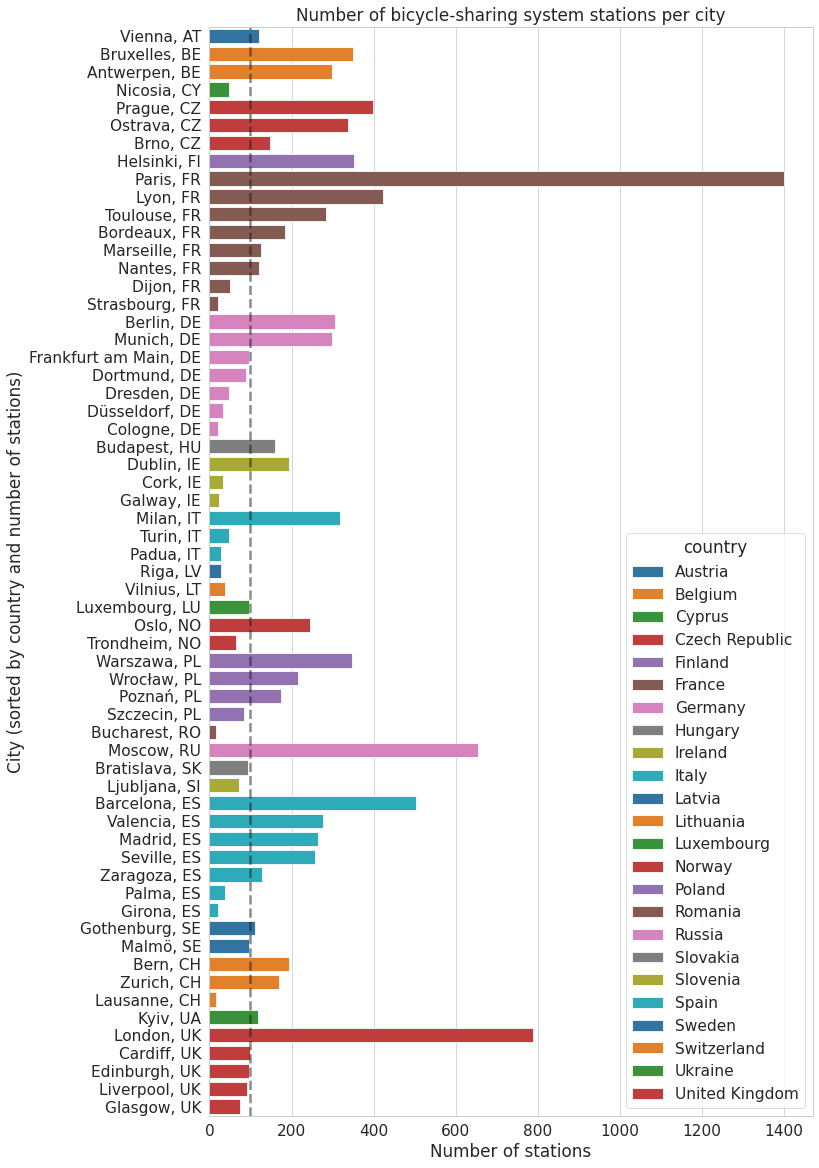

In [63]:
# fig = plt.figure(figsize=(10,20))
fig = plt.figure(figsize=(11.69,16.53))
sns.set_style("whitegrid")
# sns.set_context("paper")
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 2.5})

countries_list = df_cities.sort_values('country', ascending=True).country.unique()
# my_cmap = ListedColormap(sequential_hcl(n = len(countries_list), name = "Light Grays").colors())

# sns.set(font_scale = 1.25)

g = sns.barplot(
    data=df_cities,
    x="stations", y="city_label",
    # order=df_cities.sort_values('stations', ascending=False).city_label,
    order=df_cities.sort_values(['country', 'stations'], ascending=[True, False]).city_label,
    hue="country", dodge=False,
    hue_order=countries_list,
    palette = sns.color_palette("tab10")
    # palette = sns.color_palette(sequential_hcl(n = len(countries_list), name = "Pastel 1").colors())
    # cmap = sequential_hcl(n = len(countries_list), name = "Grays").cmap()
)

g.axvline(100, ls='--', c='k', alpha=0.5)
# g.set_axis_labels("Metric value", "Density")
# g.set_titles("{row_name}\nMetric: {col_name}")
# g.fig.subplots_adjust(wspace=0.1, hspace=0.15)
# g.fig.subplots_adjust(top=0.92) # adjust the Figure in rp
# g.fig.suptitle(f'Metrics distribution for multiple neighbour embedding methods\n[City: Warsaw, Hex resolution: {res}, Validation dataset]')

# g.set_yticklabels(g.get_yticks(), size = 18)

plt.xlabel("Number of stations")
plt.ylabel("City (sorted by country and number of stations)")
plt.title("Number of bicycle-sharing system stations per city")

# plt.xlabel("Number of stations", size=20)
# plt.ylabel("City (sorted by country and number of stations)", size=20)
# plt.title("Number of bicycle-sharing system stations per city", size=20)
plt.tight_layout()

fig.savefig('stations_per_city_all.pdf', dpi=300, format='pdf', bbox_inches='tight')

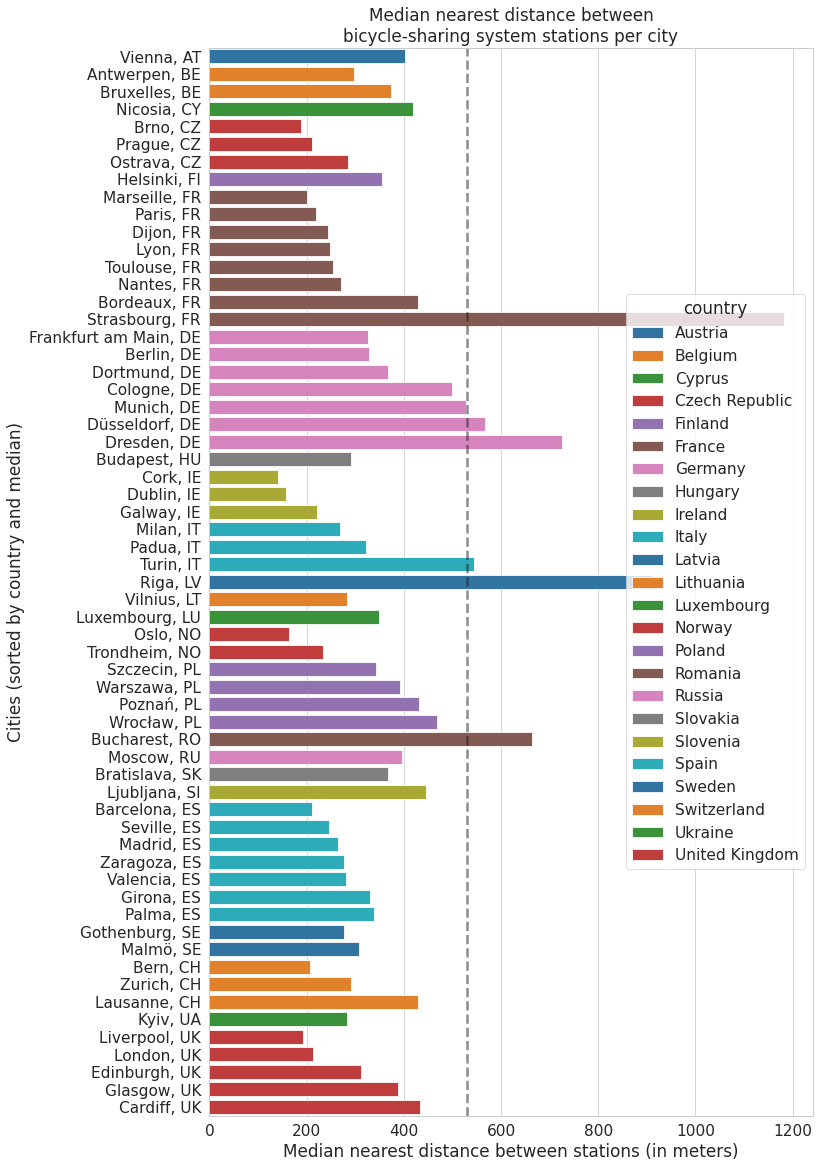

In [64]:
# fig = plt.figure(figsize=(10,20))
fig = plt.figure(figsize=(11.69,16.53))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 2.5})

countries_list = df_cities.sort_values('country', ascending=True).country.unique()
# my_cmap = ListedColormap(sequential_hcl(n = len(countries_list), name = "Light Grays").colors())

g = sns.barplot(
    data=df_cities,
    x="median_nearest_distance", y="city_label",
    # order=df_cities.sort_values('stations', ascending=False).city_label,
    order=df_cities.sort_values(['country', 'median_nearest_distance'], ascending=[True, True]).city_label,
    hue="country", dodge=False,
    hue_order=countries_list,
    palette = sns.color_palette("tab10")
    # palette = sns.color_palette(sequential_hcl(n = len(countries_list), name = "Pastel 1").colors())
    # cmap = sequential_hcl(n = len(countries_list), name = "Grays").cmap()
)

g.axvline(530, ls='--', c='k', alpha=0.5)

# g.set_yticklabels(g.get_yticks(), size = 18)

plt.xlabel("Median nearest distance between stations (in meters)")
plt.ylabel("Cities (sorted by country and median)")
plt.title("Median nearest distance between\nbicycle-sharing system stations per city")

# plt.xlabel("Median nearest distance between stations (in meters)", size=20)
# plt.ylabel("Cities (sorted by country and median)", size=20)
# plt.title("Median nearest distance between\nbicycle-sharing system stations per city", size=20)
plt.tight_layout()

fig.savefig('stations_median_distance_per_city_all.pdf', dpi=300, format='pdf', bbox_inches='tight')

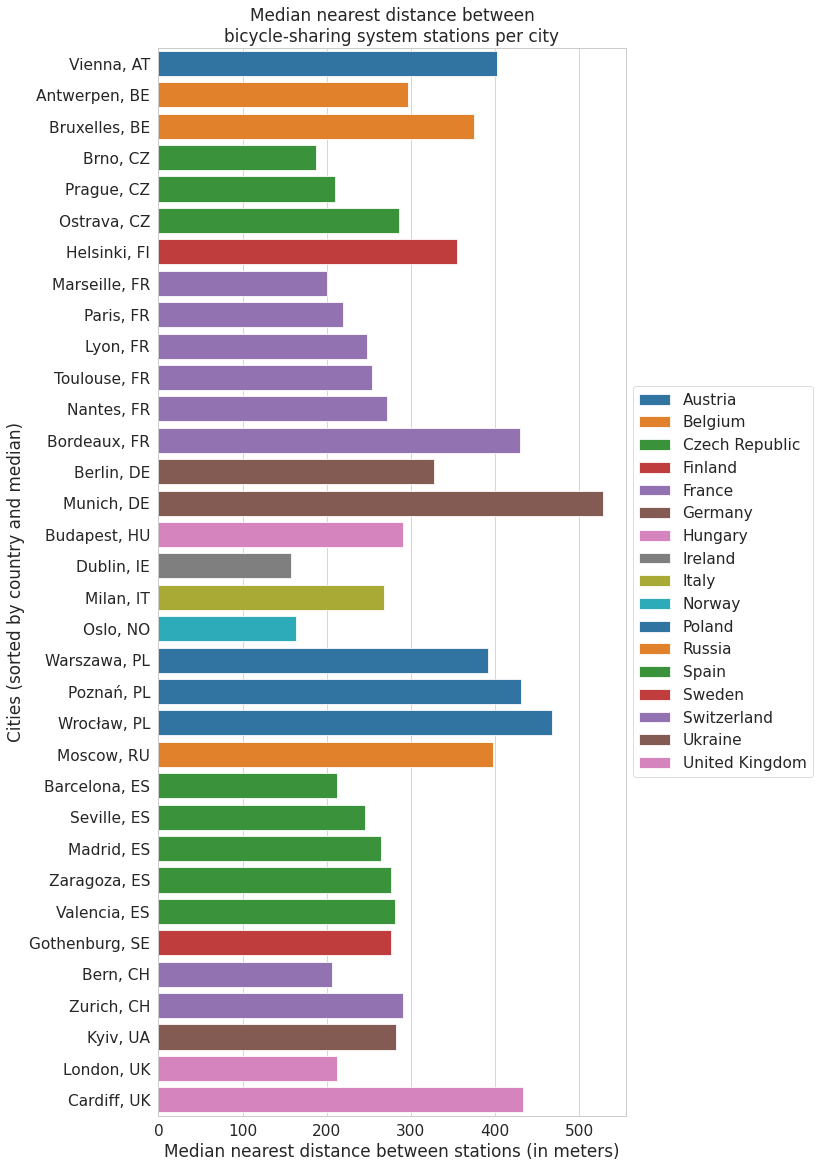

In [65]:
df_cities_filtered = df_cities.loc[df_cities.stations >= 100]
# fig = plt.figure(figsize=(10,20))
fig = plt.figure(figsize=(11.69,16.53))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 2.5})

countries_list = df_cities_filtered.sort_values('country', ascending=True).country.unique()
# my_cmap = ListedColormap(sequential_hcl(n = len(countries_list), name = "Light Grays").colors())

g = sns.barplot(
    data=df_cities_filtered,
    x="median_nearest_distance", y="city_label",
    # order=df_cities.sort_values('stations', ascending=False).city_label,
    order=df_cities_filtered.sort_values(['country', 'median_nearest_distance'], ascending=[True, True]).city_label,
    hue="country", dodge=False,
    hue_order=countries_list,
    palette = sns.color_palette("tab10"),
    # facet_kws={"legend_out": True}
    # palette = sns.color_palette(sequential_hcl(n = len(countries_list), name = "Pastel 1").colors())
    # cmap = sequential_hcl(n = len(countries_list), name = "Grays").cmap()
)

# g.axvline(530, ls='--', c='k', alpha=0.5)

# g.set_yticklabels(g.get_yticks(), size = 18)

plt.xlabel("Median nearest distance between stations (in meters)")
plt.ylabel("Cities (sorted by country and median)")
plt.title("Median nearest distance between\nbicycle-sharing system stations per city")
# g.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.xlabel("Median nearest distance between stations (in meters)", size=20)
# plt.ylabel("Cities (sorted by country and median)", size=20)
# plt.title("Median nearest distance between\nbicycle-sharing system stations per city", size=20)
plt.tight_layout()

fig.savefig('stations_median_distance_per_city_accpeted.pdf', dpi=300, format='pdf', bbox_inches='tight')

In [66]:
accepted_cities_ids = [int(n) for n in df_cities.loc[df_cities.stations >= 100].city_id.values]
discarded_cities_ids = [int(n) for n in df_cities.loc[df_cities.stations < 100].city_id.values]

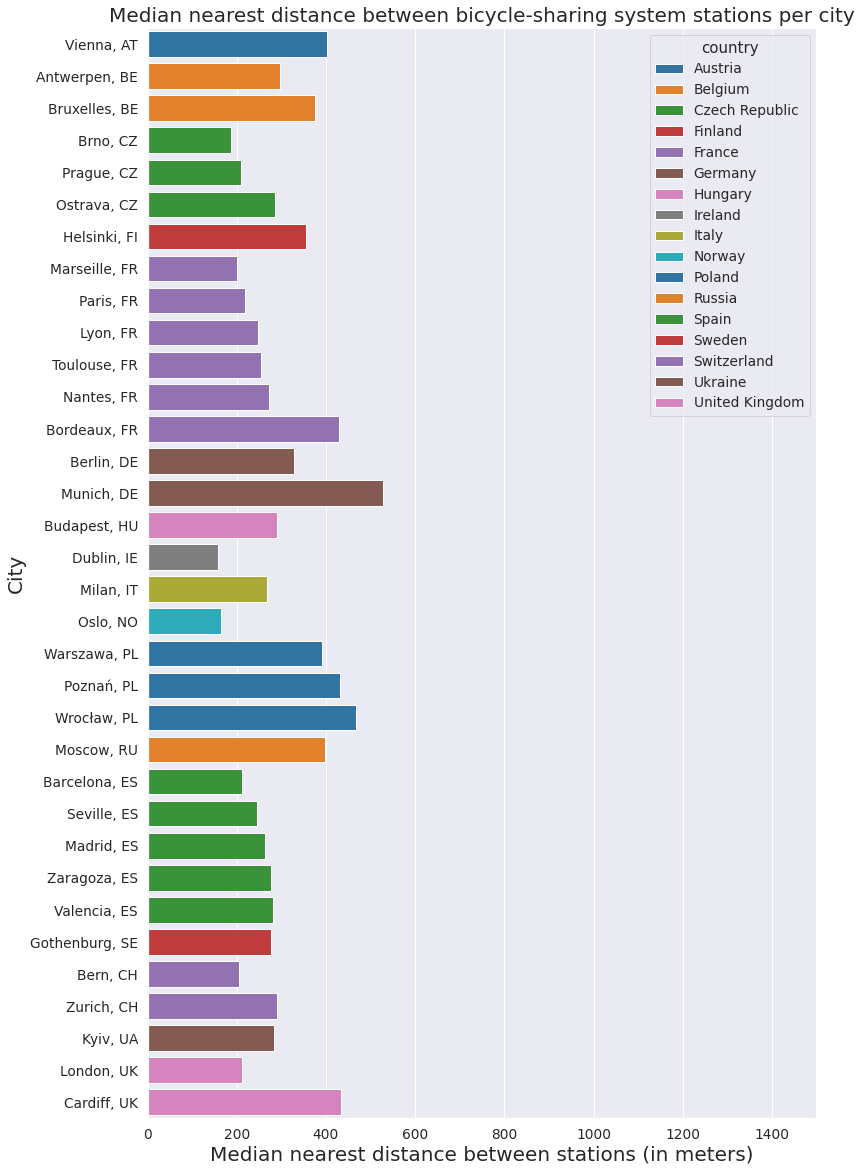

In [43]:
# fig = plt.figure(figsize=(10,20))
fig = plt.figure(figsize=(11.69,16.53))
sns.set_theme(style="whitegrid")

accepted_df = df_cities.loc[df_cities.city_id.isin(accepted_cities_ids)]

countries_list = accepted_df.sort_values('country', ascending=True).country.unique()
# my_cmap = ListedColormap(sequential_hcl(n = len(countries_list), name = "Light Grays").colors())

sns.set(font_scale = 1.25)

g = sns.barplot(
    data=df_cities,
    x="median_nearest_distance", y="city_label",
    # order=df_cities.sort_values('stations', ascending=False).city_label,
    order=accepted_df.sort_values(['country', 'median_nearest_distance'], ascending=[True, True]).city_label,
    hue="country", dodge=False,
    hue_order=countries_list,
    palette = sns.color_palette("tab10")
    # palette = sns.color_palette(sequential_hcl(n = len(countries_list), name = "Pastel 1").colors())
    # cmap = sequential_hcl(n = len(countries_list), name = "Grays").cmap()
)

g.set_xlim([0,1500])

# g.axvline(100, ls='--', c='k', alpha=0.5)

# g.set_yticklabels(g.get_yticks(), size = 18)

plt.xlabel("Median nearest distance between stations (in meters)", size=20)
plt.ylabel("City", size=20)
plt.title("Median nearest distance between bicycle-sharing system stations per city", size=20)
plt.tight_layout()

fig.savefig('accepted_stations_distance_per_city_all.pdf', dpi=300, format='pdf')

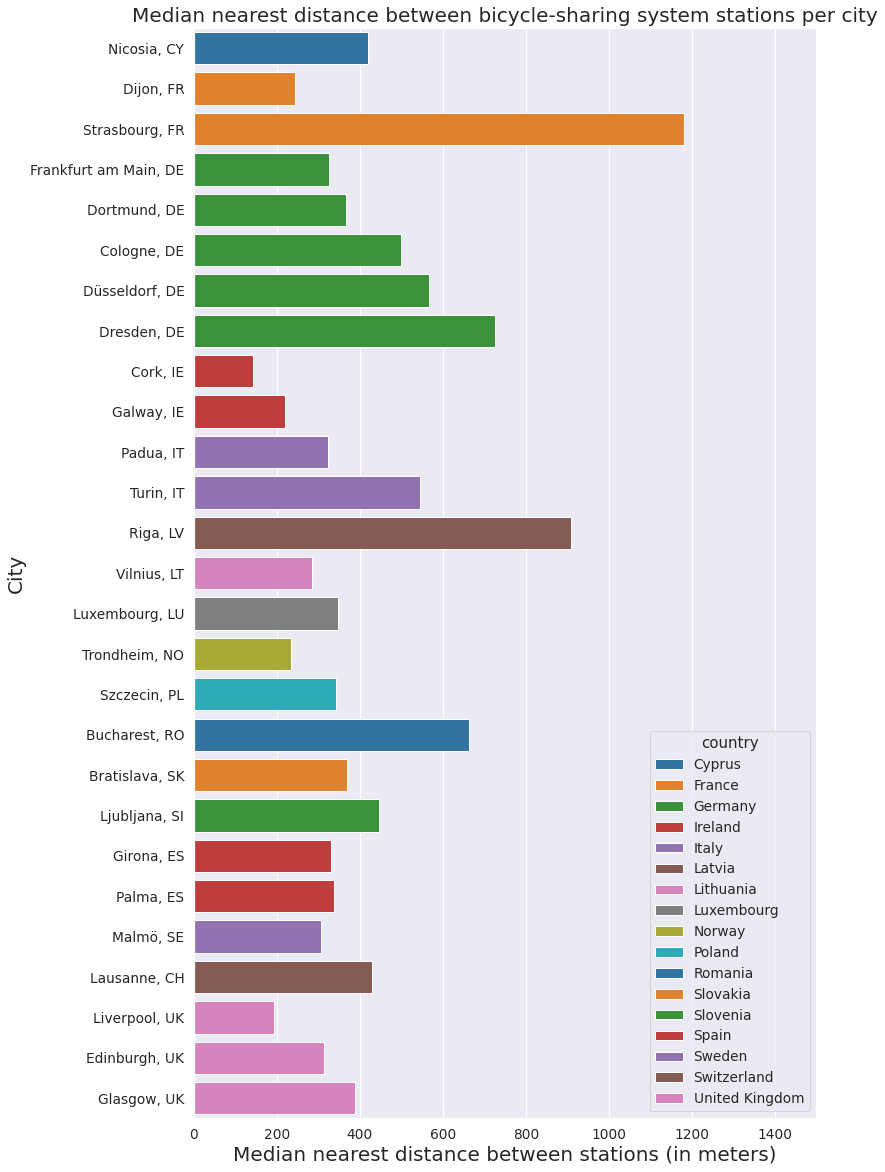

In [44]:
# fig = plt.figure(figsize=(10,20))
fig = plt.figure(figsize=(11.69,16.53))
sns.set_theme(style="whitegrid")

discarded_df = df_cities.loc[df_cities.city_id.isin(discarded_cities_ids)]

countries_list = discarded_df.sort_values('country', ascending=True).country.unique()
# my_cmap = ListedColormap(sequential_hcl(n = len(countries_list), name = "Light Grays").colors())

sns.set(font_scale = 1.25)

g = sns.barplot(
    data=df_cities,
    x="median_nearest_distance", y="city_label",
    # order=df_cities.sort_values('stations', ascending=False).city_label,
    order=discarded_df.sort_values(['country', 'median_nearest_distance'], ascending=[True, True]).city_label,
    hue="country", dodge=False,
    hue_order=countries_list,
    palette = sns.color_palette("tab10")
    # palette = sns.color_palette(sequential_hcl(n = len(countries_list), name = "Pastel 1").colors())
    # cmap = sequential_hcl(n = len(countries_list), name = "Grays").cmap()
)

g.set_xlim([0,1500])

# g.axvline(100, ls='--', c='k', alpha=0.5)

# g.set_yticklabels(g.get_yticks(), size = 18)

plt.xlabel("Median nearest distance between stations (in meters)", size=20)
plt.ylabel("City", size=20)
plt.title("Median nearest distance between bicycle-sharing system stations per city", size=20)
plt.tight_layout()

fig.savefig('discarded_stations_distance_per_city_all.pdf', dpi=300, format='pdf')

In [92]:
accepted_cities_ids

[1,
 2,
 3,
 4,
 5,
 7,
 8,
 10,
 11,
 17,
 24,
 25,
 26,
 30,
 32,
 33,
 35,
 36,
 37,
 38,
 39,
 41,
 42,
 45,
 46,
 47,
 49,
 52,
 55,
 56,
 58,
 59,
 60,
 61]

In [94]:
len(accepted_cities_ids)

34

In [95]:
discarded_cities_ids

[6,
 9,
 12,
 13,
 14,
 15,
 16,
 18,
 19,
 20,
 21,
 22,
 23,
 27,
 28,
 29,
 31,
 34,
 40,
 43,
 44,
 48,
 50,
 51,
 53,
 54,
 57]

In [96]:
len(discarded_cities_ids)

27

In [97]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_cities.loc[df_cities.city_id.isin(accepted_cities_ids)][['city_id', 'city', 'stations']].sort_values('stations', ascending=False))

,city_id,city,stations
44,45,Paris,1399.0
29,30,London,789.0
36,37,Moscow,654.0
1,2,Barcelona,502.0
31,32,Lyon,422.0
46,47,Prague,398.0
24,25,Helsinki,352.0
7,8,Bruxelles,349.0
57,58,Warszawa,347.0
41,42,Ostrava,337.0


In [98]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_cities.loc[df_cities.city_id.isin(discarded_cities_ids)][['city_id', 'city', 'stations']].sort_values('stations', ascending=False))

,city_id,city,stations
30,31,Luxembourg,96.0
18,19,Edinburgh,96.0
19,20,Frankfurt am Main,96.0
33,34,Malmö,96.0
5,6,Bratislava,95.0
27,28,Liverpool,92.0
14,15,Dortmund,88.0
50,51,Szczecin,85.0
22,23,Glasgow,75.0
28,29,Ljubljana,72.0


In [67]:
query_accept = { 'city_id': { '$in': accepted_cities_ids } }
query_discard = { 'city_id': { '$in': discarded_cities_ids } }

update_accept = { "$set": { "accepted": True } }
update_discard = { "$set": { "accepted": False } }

In [68]:
coll_cities.update_many(query_accept, update_accept)

In [69]:
coll_cities.update_many(query_discard, update_discard)

In [63]:
# coll_cleanedRelations = db.relationsInCities
# coll_cleanedRelations.create_index([("city_id", ASCENDING)])
# coll_cleanedRelations.create_index([("geometry", GEOSPHERE)])

'geometry_2dsphere'

In [75]:
# for r in tqdm(coll_relations.find()):
#     if 'amenity' in r and r['amenity'] == 'bicycle_rental':
#         continue
#     if not r['parent_osm_id'] in city_id_cache:
#         city = coll_cities.find_one({ 'osm_areas_ids': r['parent_osm_id'] })
#         city_id_cache[r['parent_osm_id']] = city['city_id']
#     new_record = {}
#     for key, value in r.items():
#         new_record[key] = value
#     del new_record['_id']
#     del new_record['parent_osm_id']
#     new_record['city_id'] = city_id_cache[r['parent_osm_id']]
#     coll_cleanedRelations.insert_one(new_record)

162319it [01:26, 1869.22it/s]


KeyboardInterrupt: 